In [1]:
%load_ext autoreload


In [41]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.optimize as op
from scipy.stats import ks_2samp
import cmasher as cmr
sys.path.append('/home/s86932rs/research/psrcelery/')
import psrcelery
from all_prof_functions import (bin_array, get_rms_bline,# check_null_prob, 
                                calc_snr, _find_off_pulse,
                                err_eigval, err_eigval_off, find_dists_outliers, rolling_out_rej,
                                bad_mjds_eigs)

try:
    from all_prof_functions import check_null_prob
except OSError:
    print("Could not import nulling analysis function")

%aimport -os -sys -np -plt -sklearn.preprocessing -sklearn.decomposition -cmr -op -ks_2samp
%autoreload 2


In [3]:
#plt.rcParams

In [4]:
# Set up some plotting stuff
plt.rc('savefig', bbox='tight')
use_bk_bgd = True #### Change this to use white backgrounds for plots  #####
if use_bk_bgd:
    plot_style = 'dark_background'
    # The CMasher package provides lots of lovely colour maps; chroma is a handy sequential cmap
    cmap = cmr.chroma_r
    c1 = cmap(0.0)
    c2 = cmap(0.1)
    c3 = cmap(0.33)
    c4 = cmap(0.55)
    c5 = cmap(0.68)
    c6 = cmap(0.815)

else:
    plot_style = 'default'
    cmap = cmr.chroma
    c1 = cmap(0.0)
    c2 = cmap(0.3)
    c3 = cmap(0.53)
    c4 = cmap(0.65)
    c5 = cmap(0.78)
    c6 = cmap(0.915)


The following cell contains variables describing the dataset and where the data are located. Change them as needed. 

In [5]:
data_dir = '/home/s86932rs/research/nudot_stuff/'
plots_dir = os.path.join(data_dir, 'plots')
psr = 'B1828-11'
freq = 1400
be = 'afb'


In [42]:
be = be.lower()
BE = be.upper()
# read data from `step_1_clean_align`
# files contain ([AD]FB_aligned, [AD]FB_mjds_new, [AD]FB_tobs, [AD]FB_temp, [AD]FB_null_prob, [AD]FB_mjds_null)
npz_file = os.path.join(data_dir, '{}_{}_arrs.npz'.format(psr, freq))
with np.load(npz_file, allow_pickle=True) as d:
    exist_AFB = False
    exist_DFB = False
    if "AFB" not in d.keys() and 'AFB_aligned' in d.keys():
        exist_AFB = True
        AFB_aligned = d['AFB_aligned']
        if 'AFB_temp' in d.keys():
            AFB_temp = d['AFB_temp']
        elif 'AFB_template' in d.keys():
            AFB_temp = d['AFB_template']
        else:
            AFB_temp = d['afb_template']
            
        if 'AFB_mjds_new' in d.keys():
            AFB_mjds_new = d['AFB_mjds_new']
        else:
            AFB_mjds_new = d['AFB_mjds']
            
        if 'AFB_tobs' in d.keys():
            AFB_tobs = d['AFB_tobs']
            
        if 'AFB_nulling' not in d.keys() and 'AFB_null_prob' in d.keys():
            AFB_null_prob = d['AFB_null_prob']
            AFB_null_mjds = d['AFB_mjds_null']

    if "DFB" not in d.keys() and 'DFB_aligned' in d.keys():
        exist_DFB = True
        DFB_aligned = d['DFB_aligned']
        if 'DFB_temp' in d.keys():
            DFB_temp = d['DFB_temp']
        elif 'DFB_template' in d.keys():
            DFB_temp = d['DFB_template']
        else:
            DFB_temp = d['dfb_template']
            
        if 'DFB_mjds_new' in d.keys():
            DFB_mjds_new = d['DFB_mjds_new']
        else:
            DFB_mjds_new = d['DFB_mjds']
            
        if 'DFB_tobs' in d.keys():
            DFB_tobs = d['DFB_tobs']
            
        if 'DFB_nulling' not in d.keys() and 'DFB_null_prob' in d.keys():
            DFB_null_prob = d['DFB_null_prob']
            DFB_null_mjds = d['DFB_mjds_null']
            
if exist_AFB:
    print("The number of AFB observations is {}, with {} bins, for a shape of {}.".format(len(AFB_mjds_new), len(AFB_temp), AFB_aligned.shape))
    if len(AFB_mjds_new) < 100 and not exist_DFB:
        print("This dataset is too small for final purpose; skipping")
        exist_AFB = False
else:
    print("There are no AFB data to analyse")

if exist_DFB:
    print("The number of DFB observations is {}, with {} bins, for a shape of {}.".format(len(DFB_mjds_new), len(DFB_temp), DFB_aligned.shape))
    if len(DFB_mjds_new) < 100 and not exist_AFB:
        print("This dataset is too small for final purpose; skipping")
        exist_DFB = False
else:
    print("There are no DFB data to analyse")


The number of AFB observations is 963, with 400 bins, for a shape of (400, 963).
The number of DFB observations is 583, with 1024 bins, for a shape of (1024, 583).


In [43]:
# this should no longer be necessary
if exist_AFB and np.any(sorted(AFB_mjds_new) != AFB_mjds_new):
    print("AFB MJDs are not sorted!!")
    sort_inds = np.argsort(AFB_mjds_new)
    AFB_mjds_new = AFB_mjds_new[sort_inds]
    AFB_aligned_new = AFB_aligned[:,sort_inds]
    if AFB_aligned_new.shape == AFB_aligned.shape:
        AFB_aligned = AFB_aligned_new
        
    if np.any(sorted(AFB_mjds_new) != AFB_mjds_new):
        print("Sorting failed!!!!")
        
if exist_DFB and np.any(sorted(DFB_mjds_new) != DFB_mjds_new):
    print("DFB MJDs are not sorted!!")
    sort_inds = np.argsort(DFB_mjds_new)
    DFB_mjds_new = DFB_mjds_new[sort_inds]
    DFB_aligned_new = DFB_aligned[:,sort_inds]
    if DFB_aligned_new.shape == DFB_aligned.shape:
        DFB_aligned = DFB_aligned_new
        
    if np.any(sorted(DFB_mjds_new) != DFB_mjds_new):
        print("Sorting failed!!!!")
    

DFB MJDs are not sorted!!


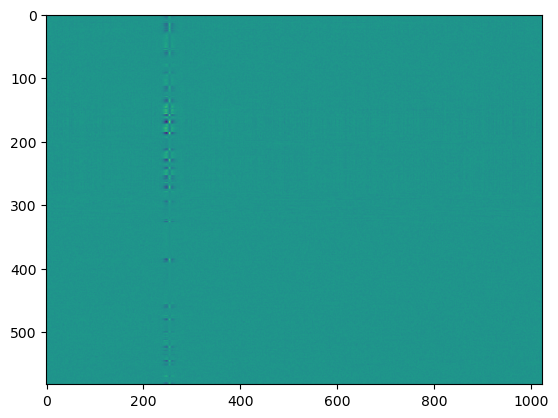

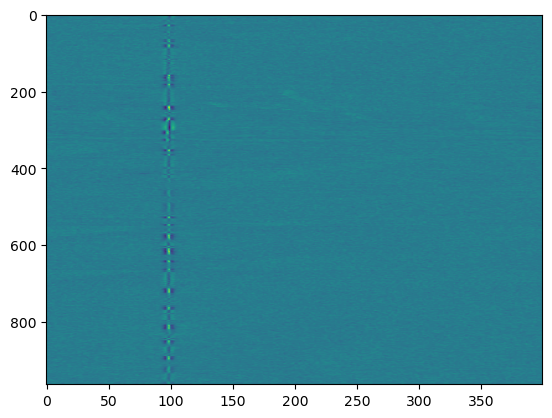

In [44]:
# Mike's alignment function
#plt.plot(DFB_aligned[:,100])   
DFB_aligned = psrcelery.data.align_and_scale(DFB_aligned.T, DFB_temp, nharm='auto').T
AFB_aligned = psrcelery.data.align_and_scale(AFB_aligned.T, AFB_temp, nharm='auto').T
#plt.plot(DFB_aligned[:,100])   
#plt.show()

DFB_offrms = np.std(DFB_aligned[400:,:], axis=0)
DFB_aligned = (DFB_aligned.T - DFB_temp).T/DFB_offrms
#plt.plot(DFB_aligned[:,100])   
#plt.show()
plt.imshow(DFB_aligned.T, aspect='auto')
plt.show()


AFB_offrms = np.std(AFB_aligned[200:,:], axis=0)
AFB_aligned = (AFB_aligned.T - AFB_temp).T/AFB_offrms
#plt.plot(AFB_aligned[:,100])   
#plt.show()
plt.imshow(AFB_aligned.T, aspect='auto')
plt.show()


In [45]:
# Try to set the phase cuts automatically
if exist_DFB:
    temp = DFB_temp
    nbin = len(DFB_temp)
elif exist_AFB:
    temp = AFB_temp
    nbin = len(AFB_temp)
    
lim, _ = _find_off_pulse(temp)
phase = np.linspace(0, 1, nbin)

# define on-pulse ranges as fractions
ip = False # Change this as necessary
one_bin = 1/nbin
peak_min = np.max(phase[lim][phase[lim] < 0.25])-2*one_bin
peak_max = np.min(phase[lim][phase[lim] > 0.25])+2*one_bin
off_min = peak_min - min(peak_min/2, 0.03)
off_max = min(2*peak_max - peak_min, 0.7)
if ip:
    ip_min = np.max(phase[lim][phase[lim] < 0.75])-2*one_bin
    ip_max = np.min(phase[lim][phase[lim] > 0.75])+2*one_bin


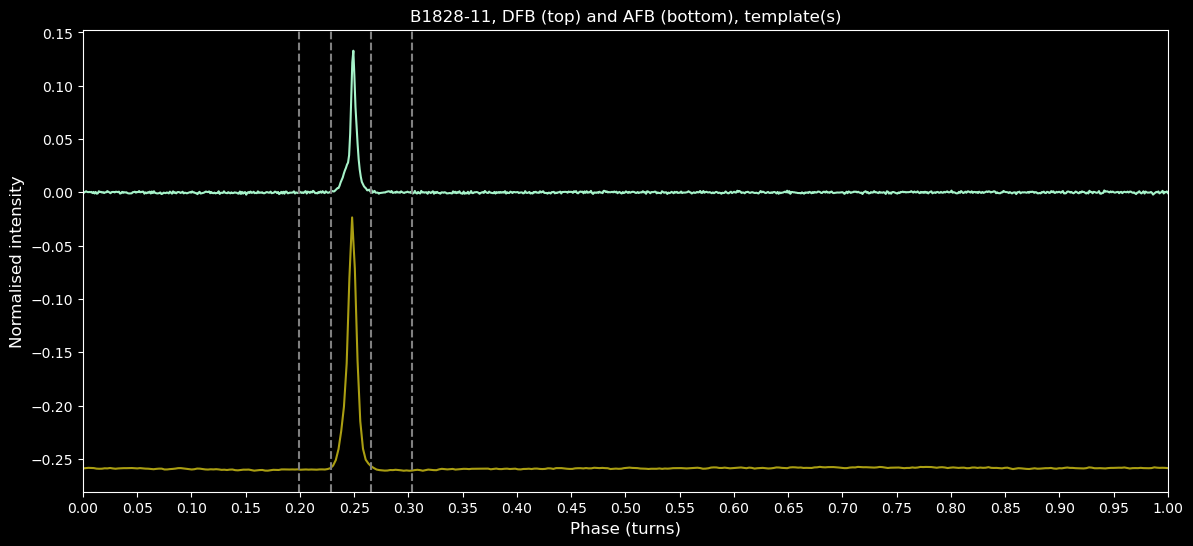

In [46]:
# plot the templates and define some useful values
if exist_AFB or exist_DFB:
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(num=1)
        fig.set_size_inches(14, 4)
        if exist_AFB and exist_DFB:
            desc = "DFB (top) and AFB (bottom)"
            fig.set_size_inches(14, 6)
        elif exist_AFB:
            desc = "AFB"
        elif exist_DFB:
            desc = "DFB"

        plt.title("{}, {}, template(s)".format(psr, desc))
        if exist_DFB:
            DFB_nbin = len(DFB_temp)
            plt.plot(np.linspace(0, 1, DFB_nbin), DFB_temp, color=c2)

        if exist_AFB:
            AFB_nbin = len(AFB_temp)
            AFB_tmp = AFB_temp - AFB_temp.max()*1.1 if exist_DFB else AFB_temp
            plt.plot(np.linspace(0, 1, AFB_nbin), AFB_tmp, color=c3)
    
        ylims = plt.ylim()
        plt.vlines([off_min, peak_min, peak_max, off_max], ylims[0], ylims[1], linestyle='dashed', colors='grey')
        if ip:
            plt.vlines([ip_mean, ip_max], ylims[0], ylims[1], linestyle='dashed', colors='grey')
        
        plt.ylim(ylims)
        plt.xticks(np.linspace(0, 1, 21))
        plt.xlim(0, 1)
        plt.ylabel('Normalised intensity', fontsize=12)
        plt.xlabel('Phase (turns)', fontsize=12)
        plt.show()


We first need to fit the profiles to get eigenvalues and eigenvectors. The eigenvectors describe the profiles, including bin-wise dependence. The eigenvalues describe the variation between profiles. Once we have the eigenvalues, we can fit GPs, and then find correlations. 

In [47]:
if exist_DFB:
    dfb_bins = np.linspace(0, 1, num=DFB_aligned.shape[0], endpoint=False)
    dfb_mask = np.logical_and(dfb_bins > off_min, dfb_bins < off_max)
    dfb_off = np.logical_or(dfb_bins[dfb_mask] < peak_min, dfb_bins[dfb_mask] > peak_max)
    if ip:
        dfb_mask = np.logical_or(dfb_mask, np.logical_and(dfb_bins > ip_min, dfb_bins < ip_max))
        dfb_off = np.logical_or(dfb_bins[dfb_mask] < peak_min, np.logical_and(dfb_bins[dfb_mask] > peak_max, dfb_bins[dfb_mask] < off_max))
    
    #dfb_range = (int(peak_min*DFB_nbin), int(peak_max*DFB_nbin))
    #dfb_range = (0, DFB_aligned.shape[0])
    dfb_pca = PCA(n_components=30)
    dfb_comps_all = dfb_pca.fit_transform(DFB_aligned[dfb_mask,:].T) * DFB_offrms.reshape(-1,1)

if exist_AFB:
    afb_bins = np.linspace(0, 1, num=AFB_aligned.shape[0], endpoint=False)
    afb_mask = np.logical_and(afb_bins > off_min, afb_bins < off_max)
    afb_off = np.logical_or(afb_bins[afb_mask] < peak_min, afb_bins[afb_mask] > peak_max)
    if ip:
        afb_mask = np.logical_or(afb_mask, np.logical_and(afb_bins > ip_min, afb_bins < ip_max))
        afb_off = np.logical_or(afb_bins[afb_mask] < peak_min, np.logical_and(afb_bins[afb_mask] > peak_max, afb_bins[afb_mask] < off_max))

    #afb_range = (int(peak_min*AFB_nbin), int(peak_max*AFB_nbin))
    #afb_range = (0, AFB_aligned.shape[0])
    afb_pca = PCA(n_components=30)
    afb_comps_all = afb_pca.fit_transform(AFB_aligned[afb_mask,:].T) * AFB_offrms.reshape(-1,1)


In [48]:
print("Check that these are number of profiles by number of components:")
if exist_AFB:
    print("AFB:", afb_comps_all.shape)
    
if exist_DFB:
    print("DFB:", dfb_comps_all.shape)
    
print("Check that these are number of components by number of bins (used):")
if exist_AFB:
    print("AFB:", afb_pca.components_.shape)
    
if exist_DFB:
    print("DFB:", dfb_pca.components_.shape)


Check that these are number of profiles by number of components:
AFB: (963, 30)
DFB: (583, 30)
Check that these are number of components by number of bins (used):
AFB: (30, 42)
DFB: (30, 107)


In [49]:
if exist_AFB:
    afb_rms, _ = get_rms_bline(AFB_aligned)
    print(len(afb_rms))
    print("The (max, median, and min) off-pulse rms for AFB are ({:.5f}, {:.5f}, {:.5f})".format(afb_rms.min(), np.median(afb_rms), afb_rms.max()))
    
if exist_DFB:
    dfb_rms, _ = get_rms_bline(DFB_aligned)
    print(len(dfb_rms))
    print("The (max, median, and min) off-pulse rms for DFB are ({:.5f}, {:.5f}, {:.5f})".format(dfb_rms.min(), np.median(dfb_rms), dfb_rms.max()))


963
The (max, median, and min) off-pulse rms for AFB are (0.61264, 1.00157, 1.37148)
583
The (max, median, and min) off-pulse rms for DFB are (0.85663, 1.01692, 1.34118)


In [50]:
if exist_DFB:
    bad_mjds_dfb = bad_mjds_eigs(DFB_aligned, DFB_mjds_new, peak_min, peak_max)
    
if exist_AFB:
    bad_mjds_afb = bad_mjds_eigs(AFB_aligned, AFB_mjds_new, peak_min, peak_max)


133
57535.2013146


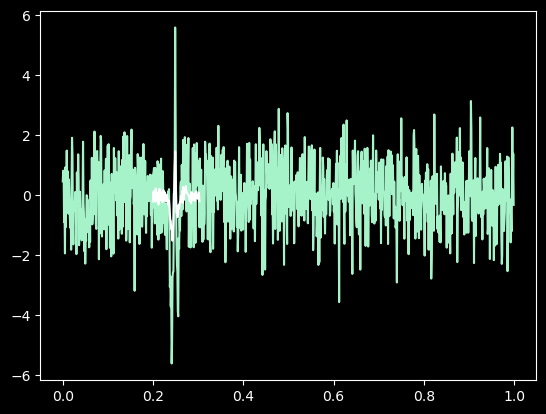

In [51]:
if exist_DFB:
    print(len(bad_mjds_dfb))
    imjd = np.random.randint(len(bad_mjds_dfb))
    bad_mjd = bad_mjds_dfb[imjd]
    #lim = DFB_mjds_new == bad_mjd
    print(bad_mjd)
    with plt.style.context(plot_style):
        plt.plot(dfb_bins, DFB_aligned[:,imjd], color=c2)
        plt.plot(dfb_bins[dfb_mask], dfb_pca.mean_, '-', color=c1)
        plt.show()


In [52]:
# define axes parameters for following plots
#w = 0.92
l1 = 0.1
b = 0.1
h = 0.82
sep = 0.08
frac = 0.5
l2 = l1 + frac + sep
w1 = frac
w2 = 1 - l2 - sep

#h1 = (0.87 - sep)/(1 + frac)
#h2 = h1*frac
#b1 = b2 + h2 + sep


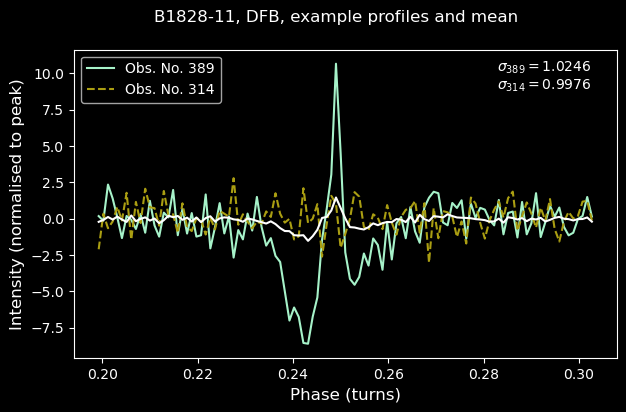

In [53]:
if exist_DFB:
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(num=1)
        fig.set_size_inches(7, 4)
        fig.suptitle("{}, DFB, example profiles and mean".format(psr))
        first, second = np.random.randint(dfb_comps_all.shape[0], size=2)
        #second = 179
        if ip:
            ax1 = fig.add_axes((l1, b, w1, h))
            ax2 = fig.add_axes((l2, b, w2, h))
            mask1 = np.logical_and(dfb_mask, dfb_bins < 0.5)
            mask2 = np.logical_and(dfb_mask, dfb_bins > 0.5)
            mean_mask1 = np.arange(len(dfb_pca.mean_)) < len(dfb_bins[mask1])
            mean_mask2 = np.arange(len(dfb_pca.mean_)) >= len(dfb_bins[mask1])
            for ax, mask, mmask in zip([ax1, ax2], [mask1, mask2], [mean_mask1, mean_mask2]):
                ax.plot(dfb_bins[mask], DFB_aligned[mask,first], color=c2, label='Obs. No. {}'.format(first)) #two example profiles of the two states
                ax.plot(dfb_bins[mask], DFB_aligned[mask,second], color=c3, ls='--', label='Obs. No. {}'.format(second))
                ax.plot(dfb_bins[mask], dfb_pca.mean_[mmask], color=c1) #mean plotted, subtracted off before computing
                ax.set_xlabel('Phase (turns)', fontsize=12)
        
            #ax1.set_xlim()
            ax = ax1

        else:
            ax = plt.gca()
            plt.plot(dfb_bins[dfb_mask], DFB_aligned[dfb_mask,first], color=c2, label='Obs. No. {}'.format(first)) #two example profiles of the two states
            plt.plot(dfb_bins[dfb_mask], DFB_aligned[dfb_mask,second], color=c3, ls='--', label='Obs. No. {}'.format(second))
            plt.plot(dfb_bins[dfb_mask], dfb_pca.mean_, color=c1) #mean plotted, subtracted off before computing
            plt.xlabel('Phase (turns)', fontsize=12)
    
        #plt.xlim(peak_min*DFB_nbin, peak_max*DFB_nbin)
        #plt.xlim(dfb_range[0], dfb_range[1])
        plt.text(0.78, 0.87, '$\sigma_{{{:d}}} = {:.4f}$\n$\sigma_{{{:d}}} = {:.4f}$'.format(first, dfb_rms[first], second, dfb_rms[second]), transform=ax.transAxes)
        #plt.text(0.025, 0.87, '$N_{{obs,purple}} = {}$\n$N_{{obs,red}} = {}$'.format(first, second), transform=ax.transAxes)
        ax.set_ylabel('Intensity (normalised to peak)', fontsize=12)
        plt.legend(loc=2)
        #plt.savefig(os.path.join(plots_dir, psr+'_dfb_{}_ex_profs.png'.format(freq)), bbox_inches='tight')
        plt.show()


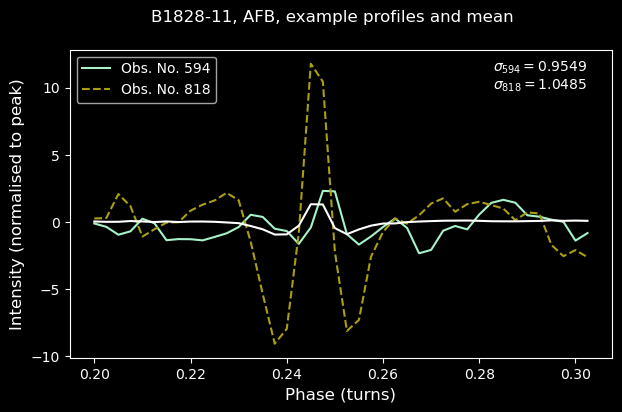

In [54]:
if exist_AFB:
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(num=1)
        fig.set_size_inches(7, 4)
        fig.suptitle("{}, AFB, example profiles and mean".format(psr))
        first, second = np.random.randint(afb_comps_all.shape[0], size=2)
        #second = 7
        if ip:
            ax1 = fig.add_axes((l1, b, w1, h))
            ax2 = fig.add_axes((l2, b, w2, h))
            mask1 = np.logical_and(afb_mask, afb_bins < 0.5)
            mask2 = np.logical_and(afb_mask, afb_bins > 0.5)
            mean_mask1 = np.arange(len(afb_pca.mean_)) < len(afb_bins[mask1])
            mean_mask2 = np.arange(len(afb_pca.mean_)) >= len(afb_bins[mask1])
            for ax, mask, mmask in zip([ax1, ax2], [mask1, mask2], [mean_mask1, mean_mask2]):
                ax.plot(afb_bins[mask], AFB_aligned[mask,first], color=c2, label='Obs. No. {}'.format(first)) #two example profiles of the two states
                ax.plot(afb_bins[mask], AFB_aligned[mask,second], color=c3, ls='--', label='Obs. No. {}'.format(second))
                ax.plot(afb_bins[mask], afb_pca.mean_[mmask], color=c1) #mean plotted, subtracted off before computing
                ax.set_xlabel('Phase (turns)', fontsize=12)
        
            #ax1.set_xlim()
            ax = ax1

        else:
            ax = plt.gca()
            plt.plot(afb_bins[afb_mask], AFB_aligned[afb_mask,first], color=c2, label='Obs. No. {}'.format(first)) #two example profiles of the two states
            plt.plot(afb_bins[afb_mask], AFB_aligned[afb_mask,second], color=c3, ls='--', label='Obs. No. {}'.format(second))
            plt.plot(afb_bins[afb_mask], afb_pca.mean_, color=c1) #mean plotted, subtracted off before computing
            plt.xlabel('Phase (turns)', fontsize=12)
    
        #plt.xlim(peak_min*AFB_nbin, peak_max*AFB_nbin)
        #plt.xlim(afb_range[0], afb_range[1])
        plt.text(0.78, 0.87, '$\sigma_{{{:d}}} = {:.4f}$\n$\sigma_{{{:d}}} = {:.4f}$'.format(first, afb_rms[first], second, afb_rms[second]), transform=ax.transAxes)
        #plt.text(0.025, 0.87, '$N_{{obs,purple}} = {}$\n$N_{{obs,red}} = {}$'.format(first, second), transform=ax.transAxes)
        plt.legend(loc=2)
        ax.set_ylabel('Intensity (normalised to peak)', fontsize=12)
        #plt.savefig(os.path.join(plots_dir, psr+'_afb_{}_ex_profs.png'.format(freq)), bbox_inches='tight')
        plt.show()


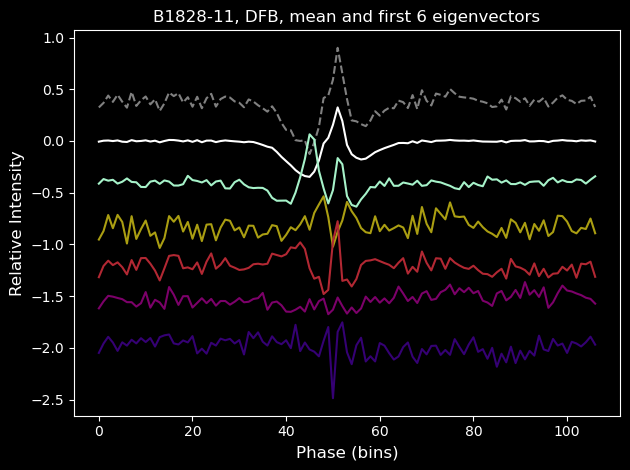

In [55]:
# plot the first five principal components
if exist_DFB:
    with plt.style.context(plot_style):
        plt.clf()
        plt.title("{}, DFB, mean and first 6 eigenvectors".format(psr))
        plt.plot(0.5*(dfb_pca.mean_/dfb_pca.mean_.max())+0.4, color='grey', ls='--')
        plt.plot(dfb_pca.components_[0,:], color=c1)
        plt.plot(dfb_pca.components_[1,:]-0.4, color=c2)
        plt.plot(dfb_pca.components_[2,:]-0.8, color=c3)
        plt.plot(dfb_pca.components_[3,:]-1.2, color=c4)
        plt.plot(dfb_pca.components_[4,:]-1.6, color=c5)
        plt.plot(dfb_pca.components_[5,:]-2, color=c6)
        plt.ylabel("Relative Intensity", fontsize=12)
        plt.xlabel("Phase (bins)", fontsize=12)

        #if dfb_range[0] == 0 and dfb_range[1] == DFB_nbin:
        #plt.xlim(peak_min*DFB_nbin, peak_max*DFB_nbin)

        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, psr+'_dfb_{}_components.png'.format(freq)), bbox_inches='tight')
        plt.show()


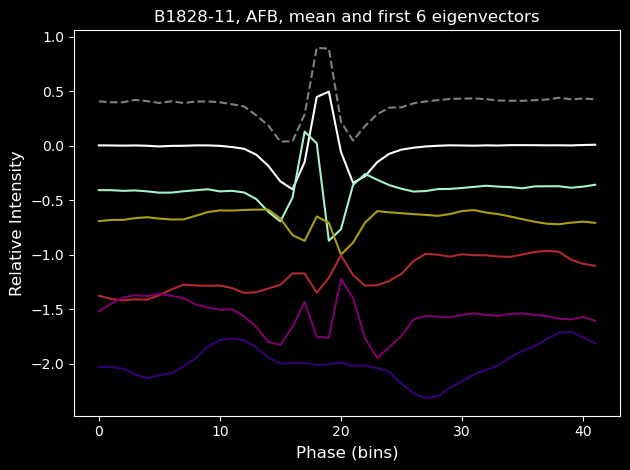

In [56]:
# plot the first five principal components
if exist_AFB:
    with plt.style.context(plot_style):
        plt.clf()
        plt.title("{}, AFB, mean and first 6 eigenvectors".format(psr))
        plt.plot(0.5*(afb_pca.mean_/afb_pca.mean_.max())+0.4, color='grey', ls='--')
        plt.plot(afb_pca.components_[0,:], color=c1)
        plt.plot(afb_pca.components_[1,:]-0.4, color=c2)
        plt.plot(afb_pca.components_[2,:]-0.8, color=c3)
        plt.plot(afb_pca.components_[3,:]-1.2, color=c4)
        plt.plot(afb_pca.components_[4,:]-1.6, color=c5)
        plt.plot(afb_pca.components_[5,:]-2, color=c6)
        plt.ylabel("Relative Intensity", fontsize=12)
        plt.xlabel("Phase (bins)", fontsize=12)

        #if afb_range[0] == 0 and afb_range[1] == AFB_nbin:
        #    plt.xlim(peak_min*AFB_nbin, peak_max*AFB_nbin)

        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, psr+'_afb_{}_components.png'.format(freq)), bbox_inches='tight')
        plt.show()


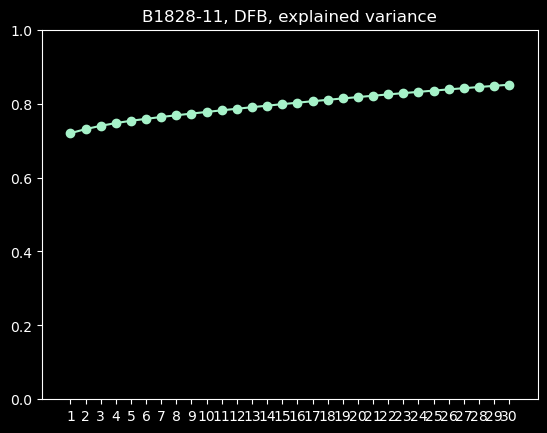

In [57]:
# explained ratio, the variance of each component, and can compute a cumulative sum
if exist_DFB:
    with plt.style.context(plot_style):
        plt.clf()
        plt.title("{}, DFB, explained variance".format(psr))
        plt.bar(np.arange(1, dfb_comps_all.shape[1]+1), dfb_pca.explained_variance_ratio_, color='None', edgecolor='k', tick_label=np.arange(1, dfb_comps_all.shape[1]+1))
        plt.plot(np.arange(1, dfb_comps_all.shape[1]+1), np.cumsum(dfb_pca.explained_variance_ratio_[:dfb_comps_all.shape[1]+1]), marker='o', color=c2)
        plt.ylim(0, 1)
        plt.savefig(os.path.join(plots_dir, psr+'_dfb_{}_variance.png'.format(freq)), bbox_inches='tight')
        plt.show()


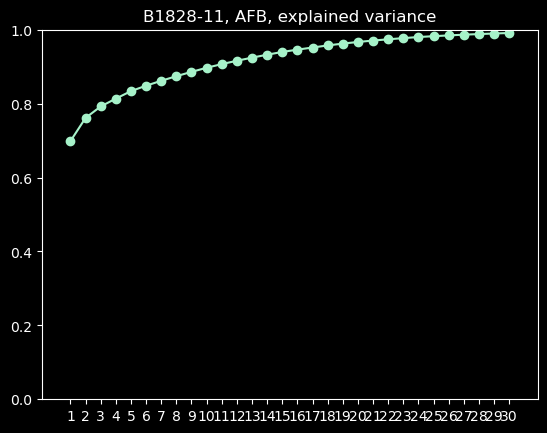

In [58]:
# explained ratio, the variance of each component, and can compute a cumulative sum
if exist_AFB:
    with plt.style.context(plot_style):
        plt.clf()
        plt.title("{}, AFB, explained variance".format(psr))
        plt.bar(np.arange(1, afb_comps_all.shape[1]+1), afb_pca.explained_variance_ratio_, color='None', edgecolor='k', tick_label=np.arange(1, afb_comps_all.shape[1]+1))
        plt.plot(np.arange(1, afb_comps_all.shape[1]+1), np.cumsum(afb_pca.explained_variance_ratio_[:afb_comps_all.shape[1]+1]), marker='o', color=c2)
        plt.ylim(0, 1)
        plt.savefig(os.path.join(plots_dir, psr+'_afb_{}_variance.png'.format(freq)), bbox_inches='tight')
        plt.show()


In [59]:
if exist_AFB:
    #print("AFB:")
    afb_errs_new = err_eigval(AFB_aligned[afb_mask,:], afb_pca.components_, afb_off) * AFB_offrms.reshape(-1,1)

if exist_DFB:
    #print("DFB:")
    dfb_errs_new = err_eigval(DFB_aligned[dfb_mask,:], dfb_pca.components_, dfb_off) * DFB_offrms.reshape(-1,1)


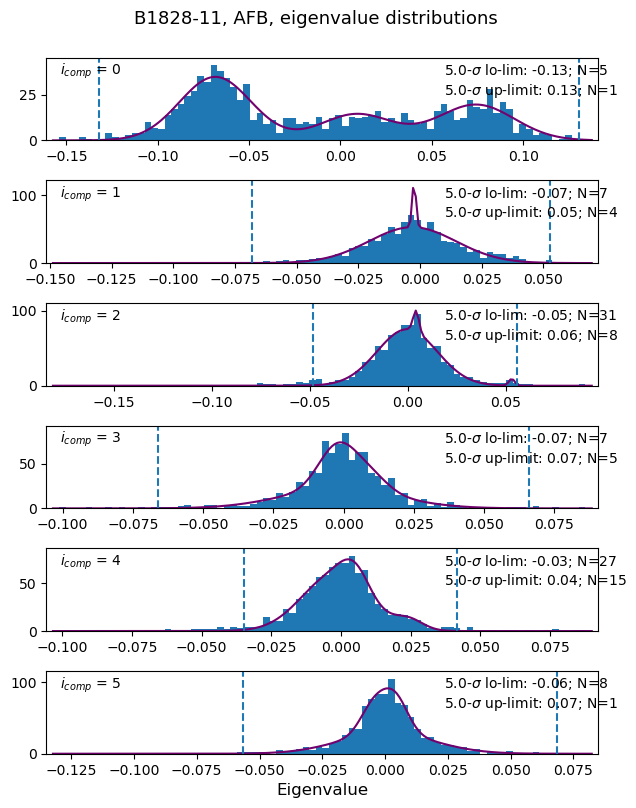

Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
Failed to fit the data with 2 gaussians; proceeding with only rough outlier excision
Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
[46860.2497648 46953.1883661 47154.4895713 47380.9496156 51378.9941234
 55294.2962176]


In [60]:
if exist_AFB:
    plt.clf()
    afb_mjds_out1 = find_dists_outliers(afb_comps_all, AFB_mjds_new, psr, 'AFB', 6, savename=os.path.join(plots_dir, psr+"_afb_{}_eigval_dists.png".format(freq)),
                                        first_out=True, sigma=5)
    afb_mjds_out2 = rolling_out_rej(afb_comps_all, AFB_mjds_new, psr, 'AFB', 6, first_out=True, show=False)
    print(afb_mjds_out1)
    #print(afb_mjds_out2)


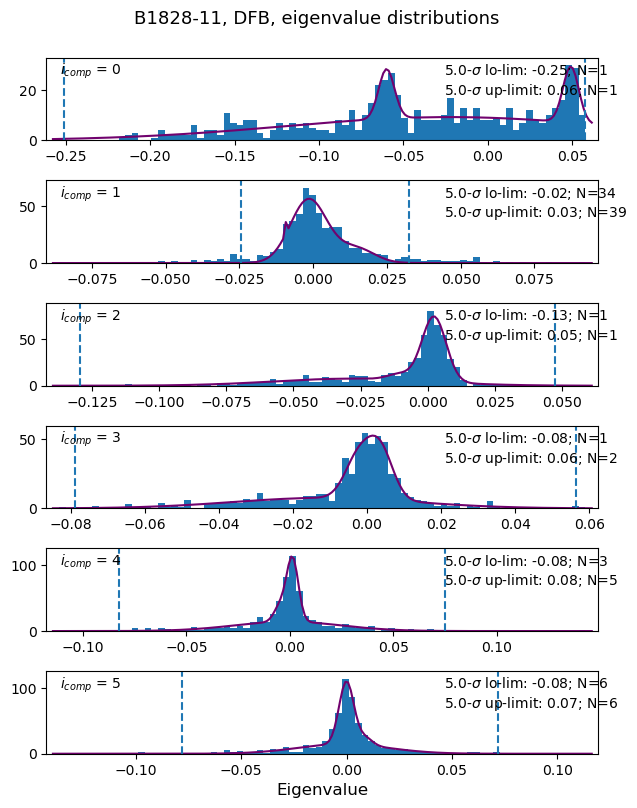

Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
Dataset too small
Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
Could not fit 3 gaussians to the data, trying 2 gaussians
[57997.902668  58701.0196148]


In [61]:
if exist_DFB:
    plt.clf()
    dfb_mjds_out1 = find_dists_outliers(dfb_comps_all, DFB_mjds_new, psr, 'DFB', 6, savename=os.path.join(plots_dir, psr+"_dfb_{}_eigval_dists.png".format(freq)),
                                        first_out=True, sigma=5)
    dfb_mjds_out2 = rolling_out_rej(dfb_comps_all, DFB_mjds_new, psr, 'DFB', 6, first_out=True, show=False)
    print(dfb_mjds_out1)
    #print(dfb_mjds_out2)


<Figure size 640x480 with 0 Axes>

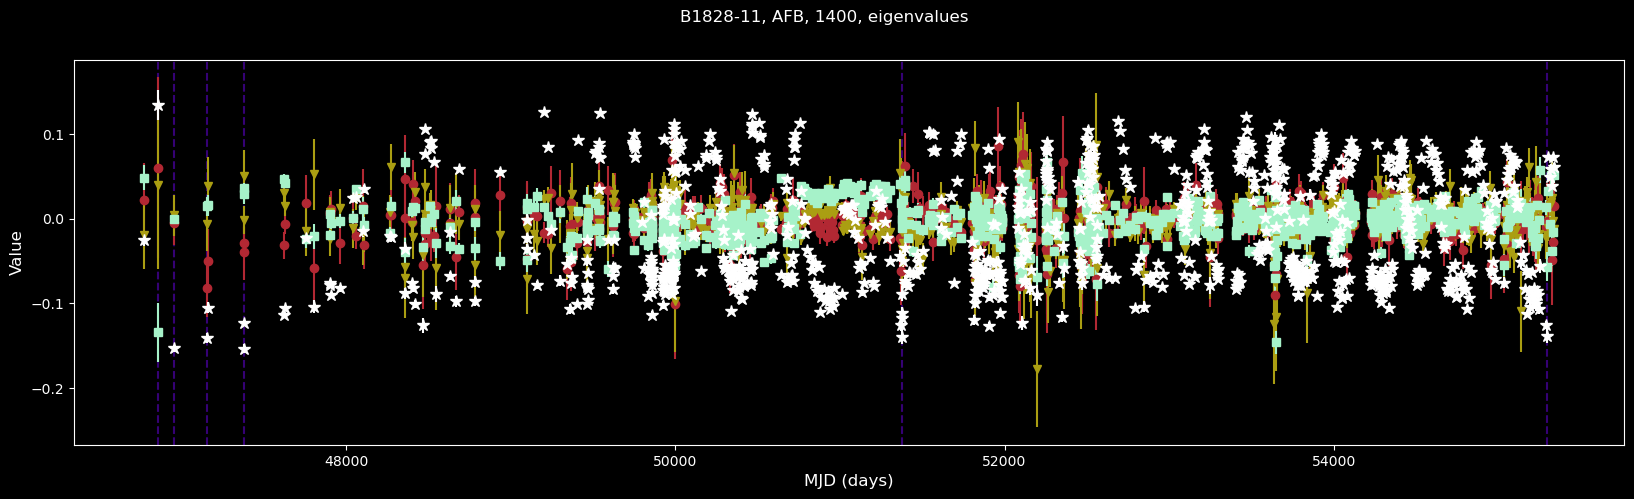

In [62]:
if exist_AFB:
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(figsize=(20, 5))
        fig.suptitle("{}, AFB, {}, eigenvalues".format(psr, freq))
        ax1 = fig.gca()
        ax1.errorbar(AFB_mjds_new, afb_comps_all[:,3], yerr=afb_errs_new[:,3], fmt='o', ecolor=c4, mec=c4, mfc=c4)
        ax1.errorbar(AFB_mjds_new, afb_comps_all[:,2], yerr=afb_errs_new[:,2], fmt='v', ecolor=c3, mec=c3, mfc=c3)
        ax1.errorbar(AFB_mjds_new, afb_comps_all[:,1], yerr=afb_errs_new[:,1], fmt='s', ecolor=c2, mec=c2, mfc=c2)
        ax1.errorbar(AFB_mjds_new, afb_comps_all[:,0], yerr=afb_errs_new[:,0], fmt='*', ecolor=c1, mec=c1, mfc=c1, ms=9)
        ax1.set_xlabel('MJD (days)', fontsize=12)
        ax1.set_ylabel('Value', fontsize=12)
        vlim = ax1.get_ylim()
        ax1.vlines(afb_mjds_out1, vlim[0], vlim[1], ls='--', color=c6, zorder=1)
        ax1.set_ylim(vlim)
        plt.savefig(os.path.join(plots_dir, "{}_afb_{}_eigs_v_mjd.png".format(psr, freq)), bbox_inches='tight')
        plt.show()


<Figure size 640x480 with 0 Axes>

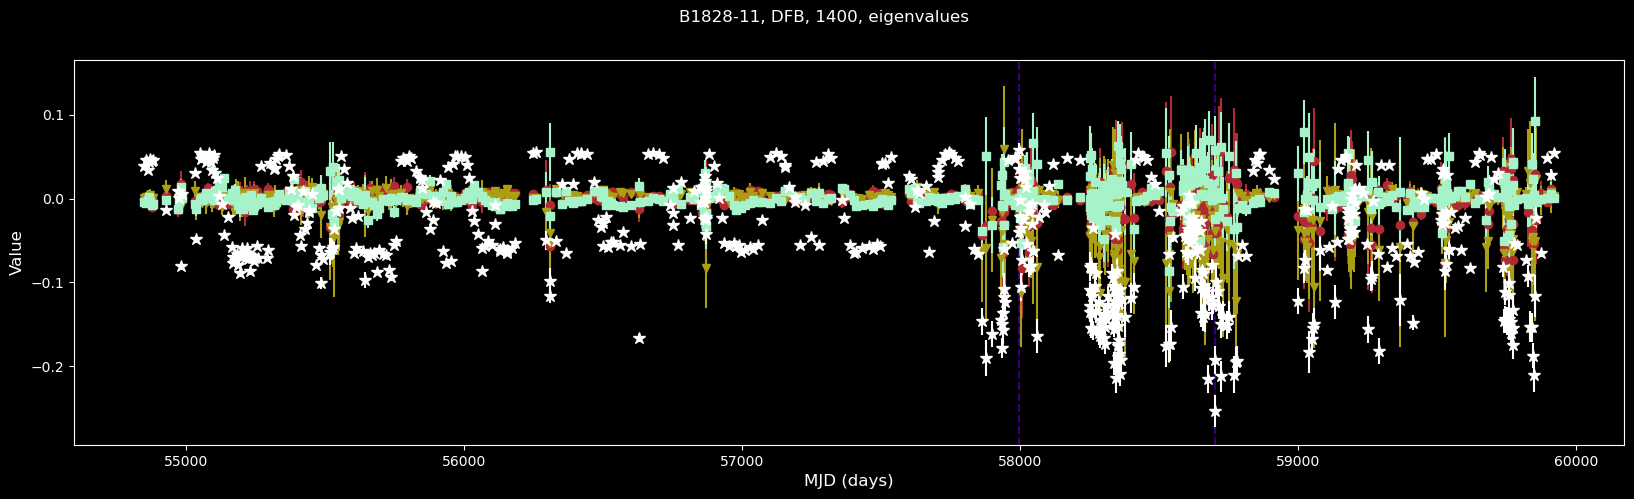

In [63]:
if exist_DFB:
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(figsize=(20, 5))
        fig.suptitle("{}, DFB, {}, eigenvalues".format(psr, freq))
        ax1 = fig.gca()
        ax1.errorbar(DFB_mjds_new, dfb_comps_all[:,3], yerr=dfb_errs_new[:,3], fmt='o', ecolor=c4, mec=c4, mfc=c4)
        ax1.errorbar(DFB_mjds_new, dfb_comps_all[:,2], yerr=dfb_errs_new[:,2], fmt='v', ecolor=c3, mec=c3, mfc=c3)
        ax1.errorbar(DFB_mjds_new, dfb_comps_all[:,1], yerr=dfb_errs_new[:,1], fmt='s', ecolor=c2, mec=c2, mfc=c2)
        ax1.errorbar(DFB_mjds_new, dfb_comps_all[:,0], yerr=dfb_errs_new[:,0], fmt='*', ecolor=c1, mec=c1, mfc=c1, ms=9)
        ax1.set_xlabel('MJD (days)', fontsize=12)
        ax1.set_ylabel('Value', fontsize=12)
        vlim = ax1.get_ylim()
        ax1.vlines(dfb_mjds_out1, vlim[0], vlim[1], ls='--', color=c6, zorder=1)
        ax1.set_ylim(vlim)
        plt.savefig(os.path.join(plots_dir, "{}_dfb_{}_eigs_v_mjd.png".format(psr, freq)), bbox_inches='tight')
        plt.show()


57943.0528227


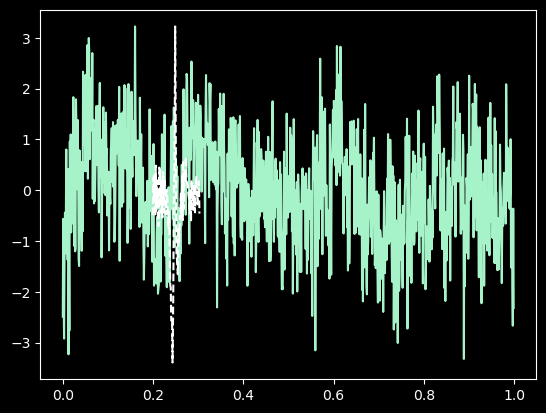

In [64]:
if exist_DFB:
    #print(len(dfb_mjds_out1))
    #bad_mjd = dfb_mjds_out1[12]
    lim = DFB_mjds_new > 38000
    imjd = np.argmax(dfb_comps_all[:,2][lim])
    bad_mjd = DFB_mjds_new[lim][imjd]
    print(bad_mjd)
    with plt.style.context(plot_style):
        plt.clf()
        plt.plot(dfb_bins, DFB_aligned[:,imjd], color=c2)
        plt.plot(dfb_bins[dfb_mask], dfb_pca.mean_*DFB_aligned[:,imjd].max()/dfb_pca.mean_.max(), '--', color=c1)
        plt.show()


46860.2497648


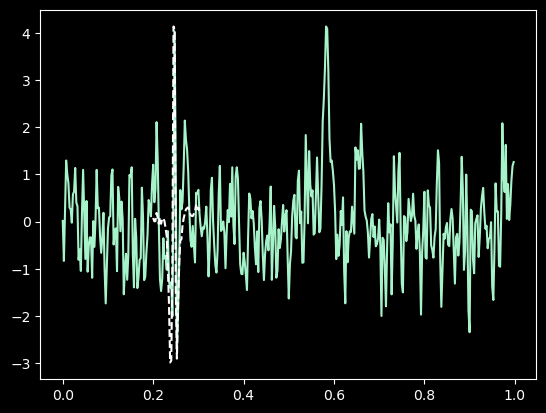

In [65]:
if exist_AFB:
    imjd = np.argmax(afb_comps_all[:,0])
    print(AFB_mjds_new[imjd])
    with plt.style.context(plot_style):
        plt.clf()
        plt.plot(afb_bins, AFB_aligned[:,imjd], color=c2)
        plt.plot(afb_bins[afb_mask], afb_pca.mean_*AFB_aligned[:,imjd].max()/afb_pca.mean_.max(), '--', color=c1)
        plt.show()


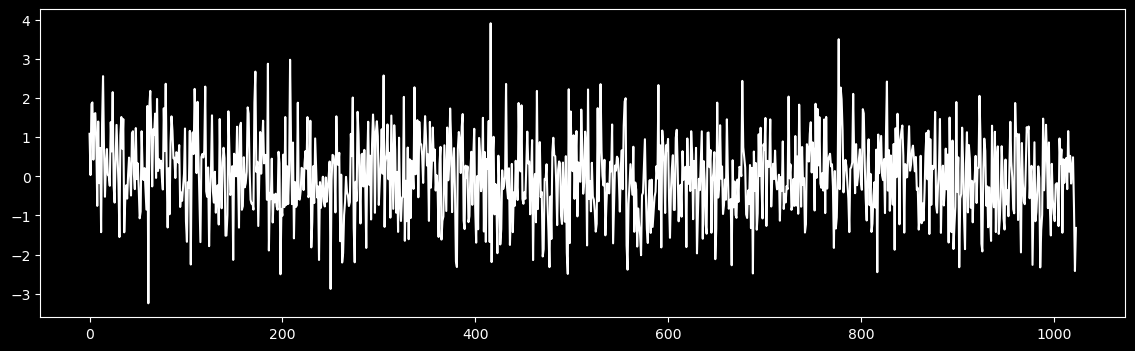

55403.0405832


In [66]:
if exist_DFB:
    ncheck = np.random.randint(len(DFB_mjds_new))
    ncheck = 69
    
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(num=1)
        fig.set_size_inches(14,4)
        plt.plot(DFB_aligned[:,ncheck], '-', color=c1)
        plt.show()
        
    print(DFB_mjds_new[ncheck])


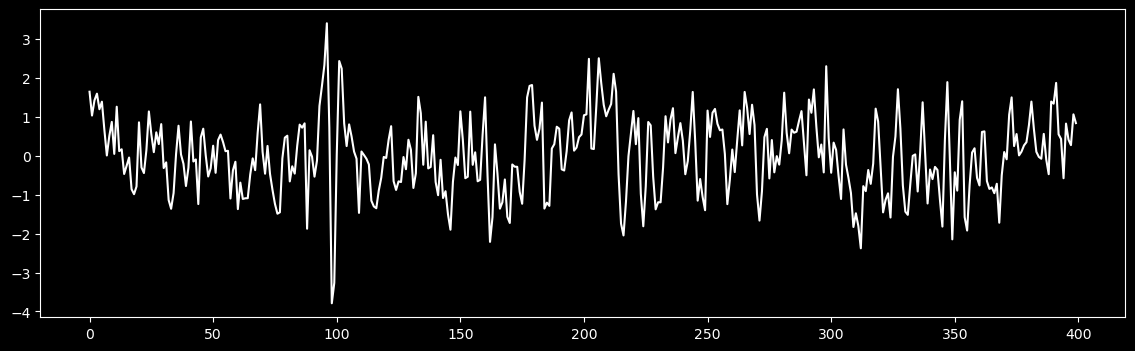

50403.7305106


In [67]:
if exist_AFB:
    ncheck = np.random.randint(len(AFB_mjds_new))
    ncheck = 223

    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(num=1)
        fig.set_size_inches(14,4)
        plt.plot(AFB_aligned[:,ncheck], '-', color=c1)
        plt.show()
        
    print(AFB_mjds_new[ncheck])


In [68]:
do_binning = False # change this if desired
# add binning lengths for pulsars into this dictionary; initial guesses from Lyne+2010
bin_lens_dict = {'B1828-11': 100,
                 'B0105+65': 100,
                 'B0329+54': 50,
                 'J0538+2817': 100,
                 'B0740-28': 50,
                 'B0059+65': 100,
                 'B0919+06': 150,
                 'B0950+08': 500,
                 'B1540-06': 400,
                 'B1642-03': 200,
                 'B1714-34': 400,
                 'B1818-04': 400,
                 'B1822-09': 100,
                 'B1826-17': 300,
                 'B1839+09': 300,
                 'B1903+07': 400,
                 'B1907+00': 400,
                 'B1929+20': 400,
                 'B1931+24': 100,
                 'B2035+36': 300,
                 'J2043+2740': 200,
                 'B2148+63': 600}

In [69]:
bin_length = bin_lens_dict[psr] if psr in bin_lens_dict.keys() else 100
bin_overlap = 0.2
twice_afb = False
if exist_DFB and do_binning:
    print("DFB:", dfb_comps_all.shape, len(DFB_mjds_new))
    try:
        binned_dfb, bin_errs_dfb, dfb_mjds_short = bin_array(dfb_comps_all, DFB_mjds_new, dfb_rms, bin_length, bin_overlap)
    except ValueError:
        print("Trying a longer bin length")
        bin_length *= 2
        binned_dfb, bin_errs_dfb, dfb_mjds_short = bin_array(dfb_comps_all, DFB_mjds_new, dfb_rms, bin_length, bin_overlap)
        twice_afb = True
        
    print("DFB:", binned_dfb.shape)
    
if exist_AFB and do_binning:
    print("AFB:", afb_comps_all.shape, len(AFB_mjds_new))
    if not twice_afb:
        try:
            binned_afb, bin_errs_afb, afb_mjds_short = bin_array(afb_comps_all, AFB_mjds_new, afb_rms, bin_length, bin_overlap)
        except ValueError:
            print("Trying a longer bin length")
            bin_length *= 2
            binned_afb, bin_errs_afb, afb_mjds_short = bin_array(afb_comps_all, AFB_mjds_new, afb_rms, bin_length, bin_overlap)
            if exist_DFB:
                binned_dfb, bin_errs_dfb, dfb_mjds_short = bin_array(dfb_comps_all, DFB_mjds_new, dfb_rms, bin_length, bin_overlap)
                print("DFB:", binned_dfb.shape)
                
    else:
        binned_afb, bin_errs_afb, afb_mjds_short = bin_array(afb_comps_all, AFB_mjds_new, afb_rms, bin_length, bin_overlap)
        
    print("AFB:", binned_afb.shape)


In [70]:
if exist_AFB and do_binning:
    with plt.style.context(plot_style):
        plt.clf()
        plt.figure(figsize=(20, 4))
        plt.title("{}, AFB, binned ({}d, {}% overlap) eigenvalues".format(psr, bin_length, int(bin_overlap*100)))
        plt.plot(afb_mjds_short, binned_afb[:,3]/max(abs(binned_afb[:,3])), 'o', color=c4)
        plt.plot(afb_mjds_short, binned_afb[:,2]/max(abs(binned_afb[:,2])), 'v', color=c3)
        plt.plot(afb_mjds_short, binned_afb[:,1]/max(abs(binned_afb[:,1])), 's', color=c2)
        plt.plot(afb_mjds_short, binned_afb[:,0]/max(abs(binned_afb[:,0])), '*', color=c1, ms=10)
        plt.show()


In [71]:
if exist_DFB and do_binning:
    with plt.style.context(plot_style):
        plt.clf()
        plt.figure(figsize=(20, 4))
        plt.title("{}, DFB, binned ({}d, {}% overlap) eigenvalues".format(psr, bin_length, int(bin_overlap*100)))
        plt.plot(dfb_mjds_short, binned_dfb[:,3]/max(abs(binned_dfb[:,3])), 'o', color=c4)
        plt.plot(dfb_mjds_short, binned_dfb[:,2]/max(abs(binned_dfb[:,2])), 'v', color=c3)
        plt.plot(dfb_mjds_short, binned_dfb[:,1]/max(abs(binned_dfb[:,1])), 's', color=c2)
        plt.plot(dfb_mjds_short, binned_dfb[:,0]/max(abs(binned_dfb[:,0])), '*', color=c1, ms=10)
        plt.show()


In [72]:
# Save the eigenvectors and eigenvalues
var_dict = {}#'val_bin_len': bin_length, 'val_bin_lap': bin_overlap}
if exist_AFB:
    var_dict['AFB_errs'] = afb_errs_new
    var_dict['AFB_mean'] = afb_pca.mean_
    var_dict['AFB_values'] = afb_comps_all
    var_dict['AFB_vectors'] = afb_pca.components_
    var_dict['AFB_mjds'] = AFB_mjds_new
    #var_dict['AFB_bin_vals'] = binned_afb
    #var_dict['AFB_bin_mjds'] = afb_mjds_short
    var_dict['AFB_rms'] = afb_rms

if exist_DFB:
    var_dict['DFB_errs'] = dfb_errs_new
    var_dict['DFB_mean'] = dfb_pca.mean_
    var_dict['DFB_values'] = dfb_comps_all
    var_dict['DFB_vectors'] = dfb_pca.components_
    var_dict['DFB_mjds'] = DFB_mjds_new
    #var_dict['DFB_bin_vals'] = binned_dfb
    #var_dict['DFB_bin_mjds'] = dfb_mjds_short
    var_dict['DFB_rms'] = dfb_rms


In [73]:
out_file = os.path.join(data_dir, '{}_{}_eigs.npz'.format(psr, freq))
if exist_AFB or exist_DFB:
    old_dict = {}
    if os.path.exists(out_file):
        with np.load(out_file, allow_pickle=True) as f:
            for key in f.keys():
                if key not in var_dict.keys():
                    old_dict[key] = f[key]
                else:
                    print("Replacing an older value for "+key)
                
    np.savez(out_file, **var_dict, **old_dict)
elif os.path.exists(out_file):
    print("No dataset to save but removing an old npz file:", out_file)
    os.remove(out_file)


Replacing an older value for AFB_errs
Replacing an older value for AFB_mean
Replacing an older value for AFB_values
Replacing an older value for AFB_vectors
Replacing an older value for AFB_mjds
Replacing an older value for AFB_rms
Replacing an older value for DFB_errs
Replacing an older value for DFB_mean
Replacing an older value for DFB_values
Replacing an older value for DFB_vectors
Replacing an older value for DFB_mjds
Replacing an older value for DFB_rms
